# Cable Weight

This notebook illustrates how the weight of cables is incorporated in the `Cable` node.

Modeling wires or chains with significant weight is typically done using the (elastic) catanary equation. This equation can not be solved anayltically meaning that numerical methods are needed to get a solution. In DAVE this can be done numerically using the `Beam` nodes.

For wires under tension the elastic catenary equations can be estimated. This estimation is accurate when the load in the cable exceeds the weight of the cable itself. This is very much the case for rigging applications where the load in a sling/grommet is typically more than 10 times the weight of the sling/grommet itself.

This weight estimation is included as on option in `Cable` nodes. In comparison with beams, cables nodes are much more versatile as they can run over sheaves/circles. They are therefore preferred when modelling rigging.

## The weight model

Calculation of forces in cables without weight is done based on the stretch and elasticity of the cable. If cable weight is included then the weight contributions of the cable are added to those forces as follows:

1. Calculate the forces in the cable as if the cable is weightless
2. Cut the cable into segments at the positions where it enters/leaves a circle or where it runs over a point
3. For free segments (segments not on a circle), calculate the contribution of the weight and add this as forces to the endpoint of the segment.
4. For other segments (the parts of a wire on a circle), calculate the weight and add it to the circle at the location between the enter/leave points of the cable.

What does that look like?

First define a small helper function to show the weight contributions. This is done by adding them as forces to the scene. This is for illustration only, it does not physically do anything:

In [120]:
from DAVE import *
from DAVE.jupyter import show, report

def _add_weight_forces_as_forces(s, cab):

    points = cab._vfNode.weight_forces_locations
    forces = cab._vfNode.weight_forces

    for point, force in zip(points, forces):
        p = s.new_point(s.available_name_like('point'), position=point)
        p.y = p.y - 1 # move visual towards camera such that is it not hidden in circle
        s.new_force(s.available_name_like('force'), parent=p, force= force)

Now create a scene, and add two endpoints and a body with a circle.

In [24]:
s = Scene()

s.new_point(name='Point')
s.new_point(name='Right',
            position=(10.0,0,-7.0))

s.new_rigidbody(name='Body',
                mass=3.0,
                fixed=False,
                position = (2,0,-20))
s.new_point(name='Point_on_body',
            parent='Body',
            position=(0.0,0.0,2.0))
s.new_circle(name='Circle',
             parent='Point_on_body',
             axis=(0.0, 1.0, 0.0),
             radius=1.0);

Add a cable with a mass and a relatively low EA

In [25]:

# code for cable
cab = s.new_cable(name='cable',
                  endA='Right',
                  endB='Point',
                  length=15,
                  EA=1000.0,
                  sheaves=['Circle'],
                  mass = 3,
                  )

Solve statics

In [26]:
s.solve_statics();

and add some visuals at the endpoints, use the helper to visualize the forces and create a screenshot

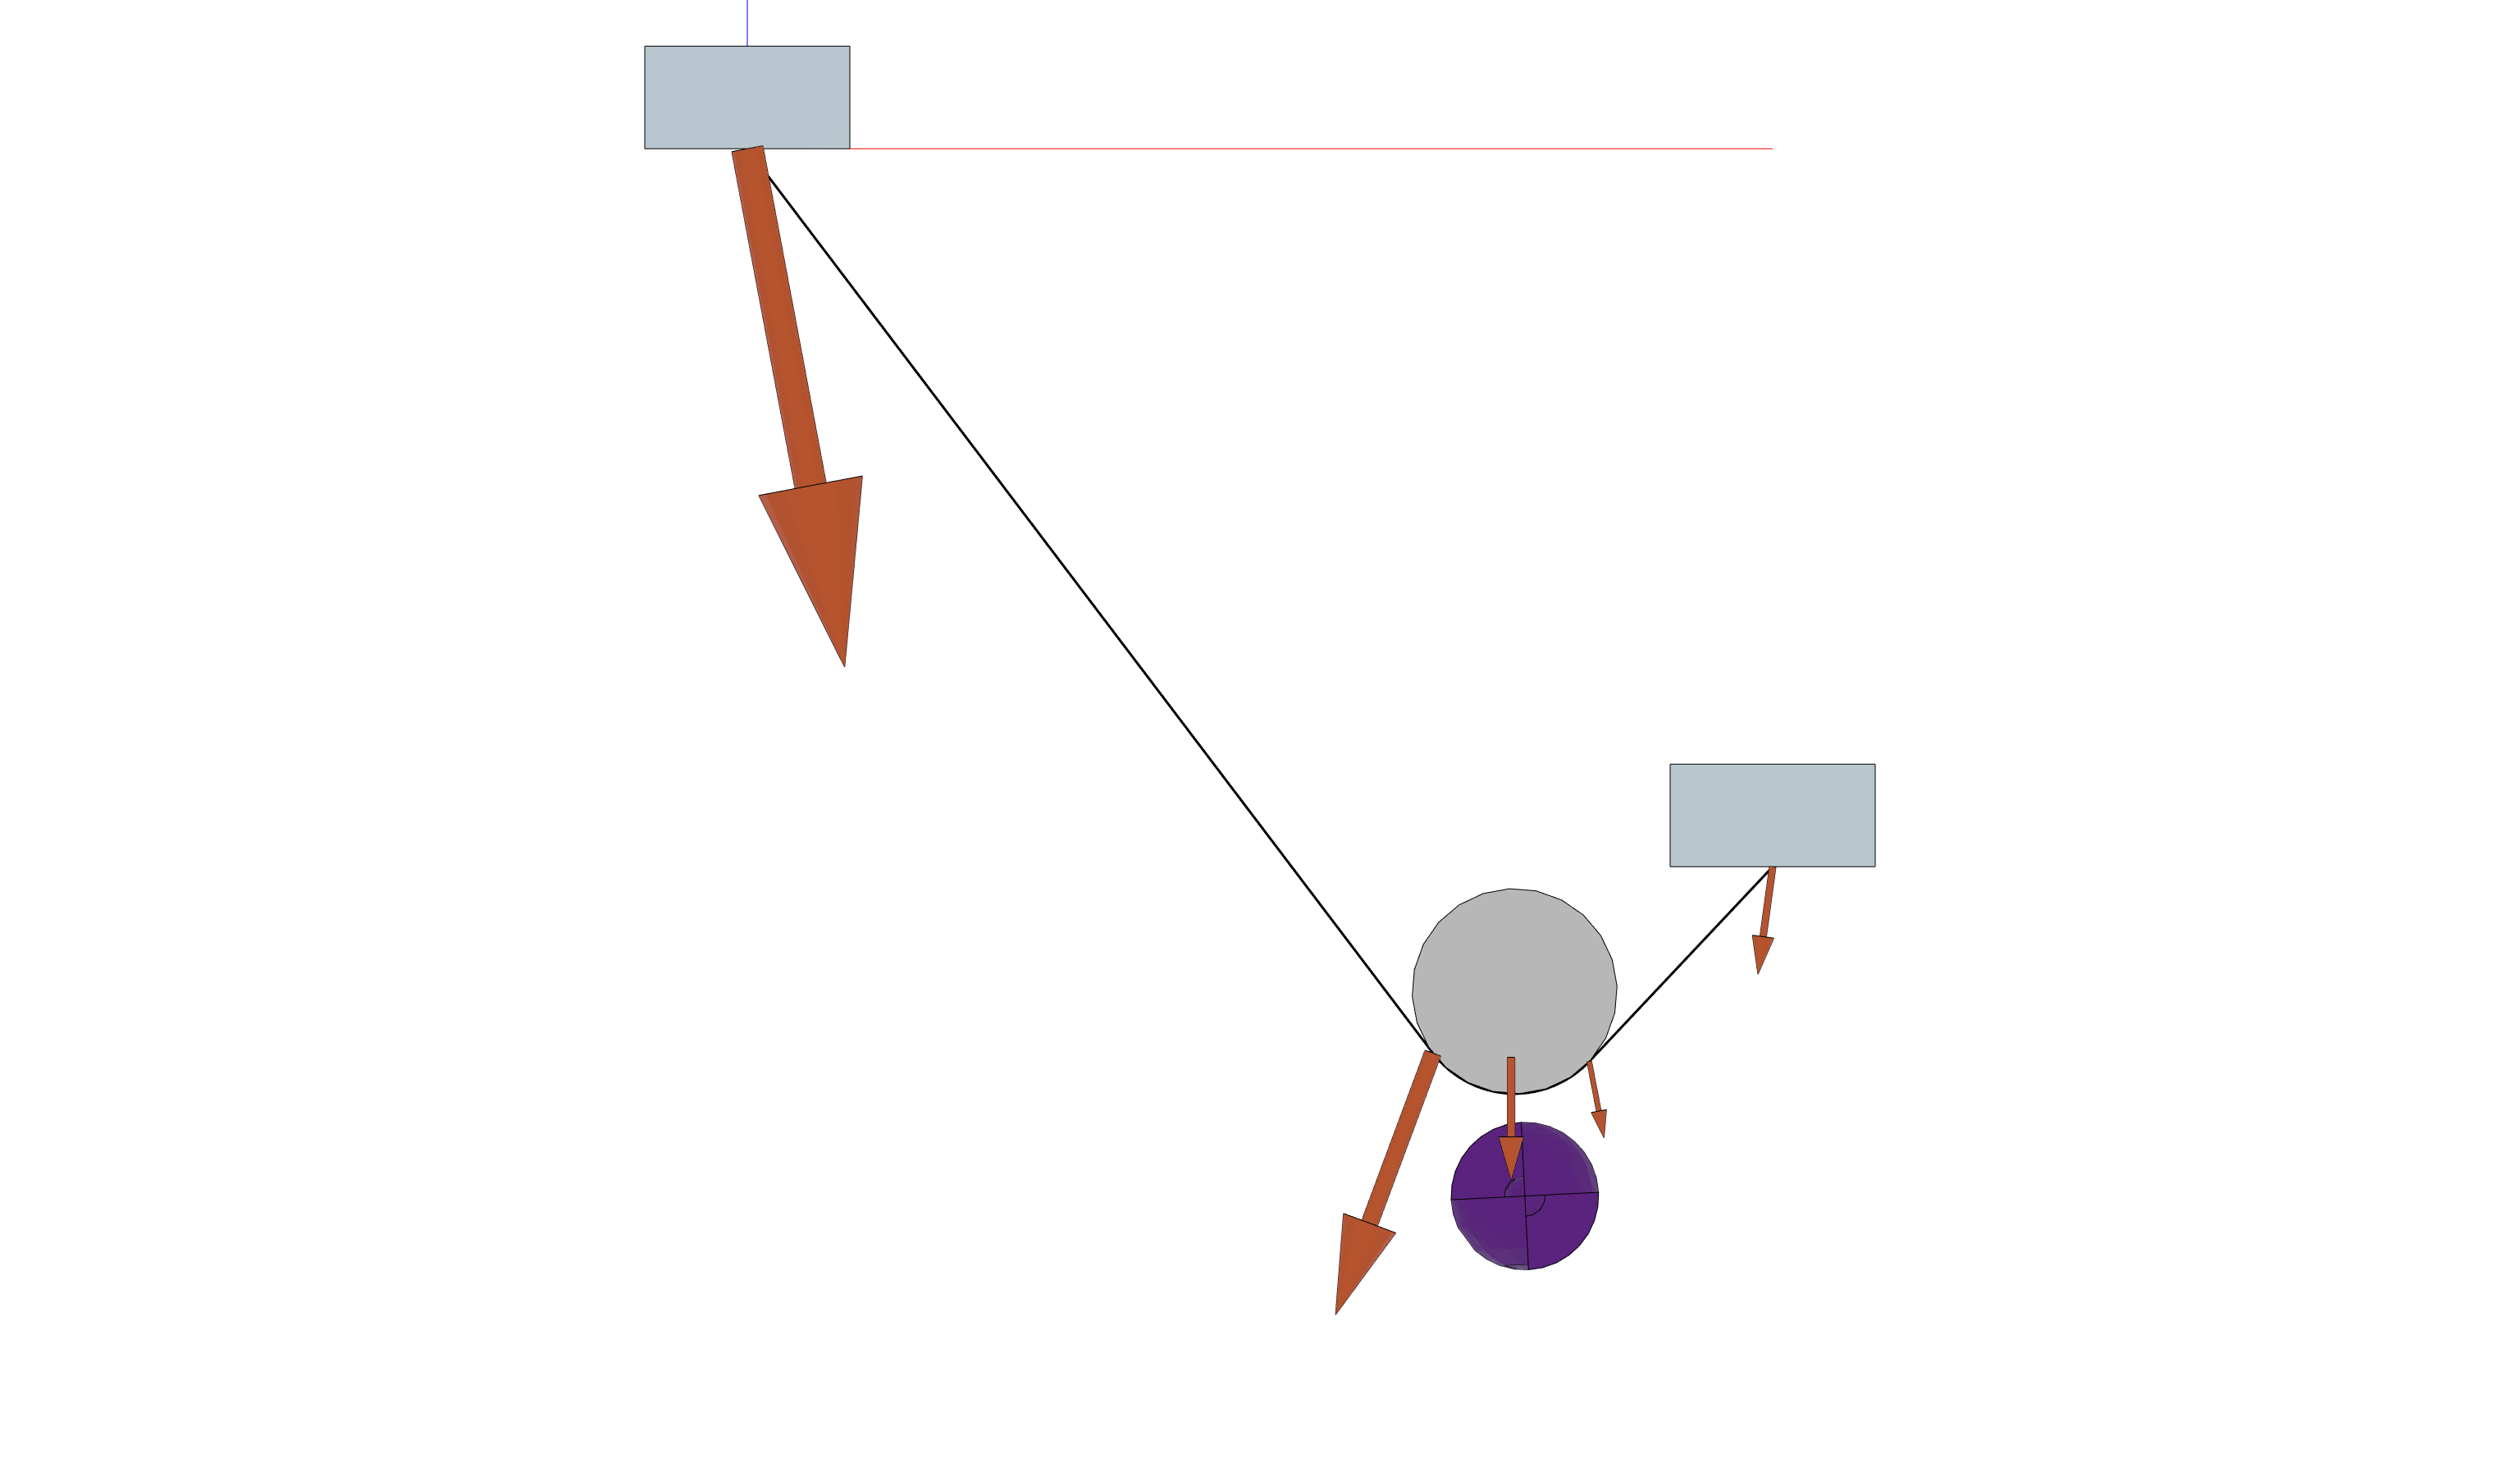

In [27]:
s.new_frame(name='Frame')
s.new_visual(name='Visual',
             parent='Frame',
             path=r'res: cube.obj',
             offset=(0.0, 0.0, 0.5),
             rotation=(0, 0, 0),
             scale=(2.0, 1.0, 1.0))
s.new_visual(name='Visual_1',
             parent='Frame',
             path=r'res: cube.obj',
             offset=(10.0, 0.0, -6.5),
             rotation=(0, 0, 0),
             scale=(2.0, 1.0, 1.0))

_add_weight_forces_as_forces(s, cab)

show(s, camera_pos=(5, -29, -5.75),
               projection='2d',
               scale=7.2,
               lookat='y',
               force_do_normalize=False,
               force_scale=360.0,
               geometry_scale=0.01,
               painters='Construction',
               zoom_fit=False)

The result shows the weight forces added to the three segments.

The forces on the ends of the left segment are higher as the left segment is longer (and thus heavier). The force in the middle (towards the purple CoG visual) is the force applied as result of the length of the wire on the circle.

Note that the forces due to weight are applied independently after applying the forces due to stretch. The wire does not re-distribute as results of the weight-forces to equalize. This makes the wire-tension discontinuous at contact points. In other words: there is friction, but only against weight forces.
The result is that, because the wire on the left is longer and thus heavier, there is a resulting counter-clockwise moment on the suspended body in the middle. As a result is receives a small counter-clockwise rotation (in the visual the CoG is slightly towards the right of the circle).

## Single segment comparison to catenary

To judge the accuracy of the model we can compare a single segment between two points with a catenary modelled by a beam node.


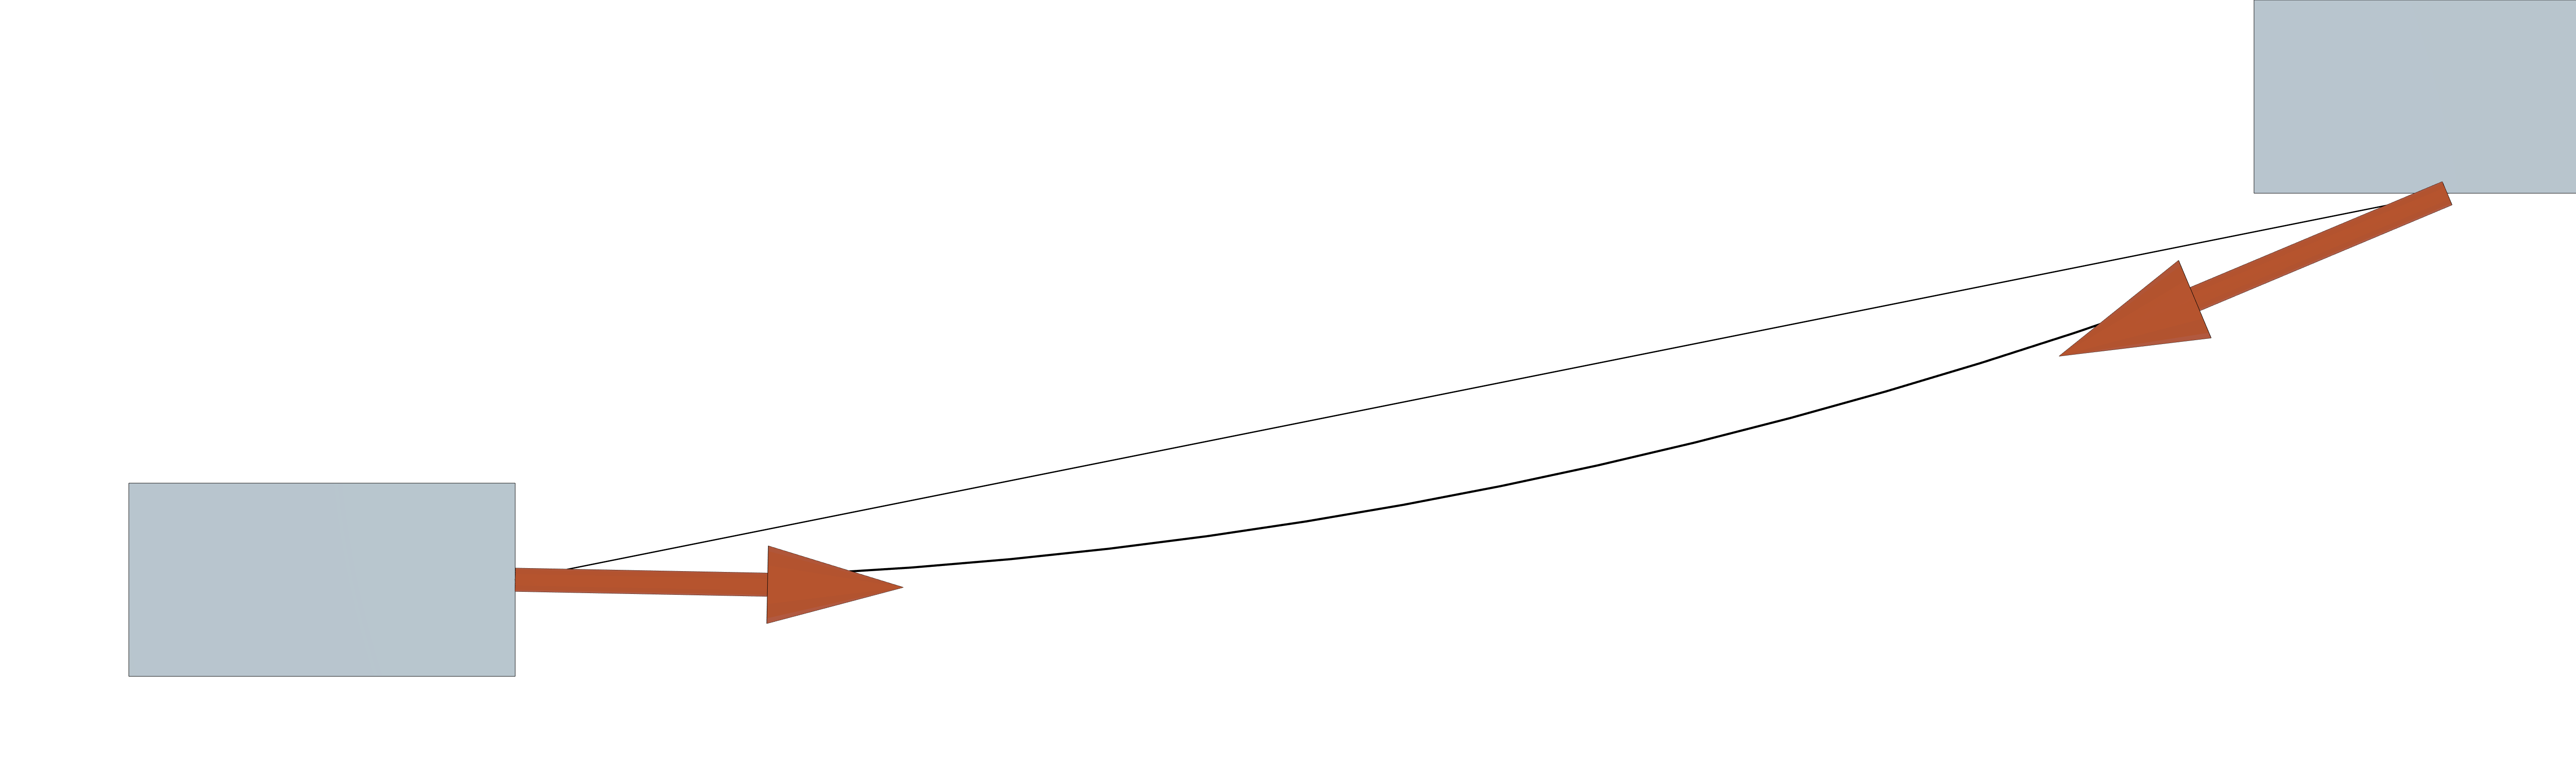

In [99]:
s = Scene()

EA = 10000

s.new_point(name='Left', position = (0,0,-12))
s.new_point(name='Right',
            position=(10.0, 0, -10))

# code for cable
cab = s.new_cable(name='cable',
                  endA='Right',
                  endB='Left',
                  EA=EA,
                  mass=3,
                  )

# Visuals
s.new_frame(name='Frame')
s.new_visual(name='Visual',
             parent='Frame',
             path=r'res: cube.obj',
             offset=(-1.0, 0.0, -12.0),
             rotation=(0, 0, 0),
             scale=(2.0, 1.0, 1.0))

s.new_visual(name='Visual_1',
             parent='Frame',
             path=r'res: cube.obj',
             offset=(10.0, 0.0, -9.5),
             rotation=(0, 0, 0),
             scale=(2.0, 1.0, 1.0))

f1 = s.new_frame('f1', position = s['Left'].position)
f2 = s.new_frame('f2', position = s['Right'].position)

beam = s.new_beam('beam', f1, f2, EA = cab.EA, mass=cab.mass, n_segments=20, tension_only=True, L=cab.length)

s.solve_statics()
# Gui(s)

_add_weight_forces_as_forces(s, cab)

plotter = show(s, camera_pos=(4, -20, -11),
               projection='2d',
               scale=2,
               lookat='y',
               force_do_normalize=False,
               force_scale=30.0,
               geometry_scale=0.01,
               painters='Construction',
               width = 2000,
               height = 600)

The straight line is the cable, the curved line is a beam catenary with the same length, EA and mass.

It is clear that the weight forces are, as expected, in line with the shape of the catenary.

We can check the forces as well.

Left end

In [101]:
report(s['Left'],['fx','fz'])
report(s['f1'],('connection_force_x','connection_force_z'))

Property,Value,Unit,Remarks,Explained
fx,66.968,kN,parent axis,x component of applied force
fz,-1.316,kN,parent axis,z component of applied force


Property,Value,Unit,Remarks,Explained
connection_force_x,68.395,kN,Parent axis,The x-component of the connection-force vector
connection_force_z,-0.833,kN,Parent axis,The z-component of the connection-force vector


Right end

In [102]:
report(s['Right'],['fx','fz'])
report(s['f2'],('connection_force_x','connection_force_z'))

Property,Value,Unit,Remarks,Explained
fx,-66.968,kN,parent axis,x component of applied force
fz,-28.104,kN,parent axis,z component of applied force


Property,Value,Unit,Remarks,Explained
connection_force_x,-68.395,kN,Parent axis,The x-component of the connection-force vector
connection_force_z,-28.587,kN,Parent axis,The z-component of the connection-force vector


These values should have been equal, but they are not.

The reason for the difference is that the estimation model is only valid if the tension in the cable due to stretch is at least the weight of the cable. In this case the stretch in the cable is 0 (the unstretched length of the cable is equal to the distance between the points).

If the cable is made slightly shorter then the result will improve:

In [104]:
s['cable'].length = 10
s['cable'].mass = 3
s['beam'].L = 10
s.solve_statics()

report(s['cable'],'tension')
report(s['Right'],['fx','fz'])
report(s['f2'],('connection_force_x','connection_force_z'))
report(s['Left'],['fx','fz'])
report(s['f1'],('connection_force_x','connection_force_z'))

Property,Value,Unit,Remarks,Explained
tension,216.093,kN,,Tension in the cable


Property,Value,Unit,Remarks,Explained
fx,-202.011,kN,parent axis,x component of applied force
fz,-55.112,kN,parent axis,z component of applied force


Property,Value,Unit,Remarks,Explained
connection_force_x,-202.145,kN,Parent axis,The x-component of the connection-force vector
connection_force_z,-55.206,kN,Parent axis,The z-component of the connection-force vector


Property,Value,Unit,Remarks,Explained
fx,202.011,kN,parent axis,x component of applied force
fz,25.692,kN,parent axis,z component of applied force


Property,Value,Unit,Remarks,Explained
connection_force_x,202.145,kN,Parent axis,The x-component of the connection-force vector
connection_force_z,25.786,kN,Parent axis,The z-component of the connection-force vector


It is good to mention that the sum of the vertical forces at both ends is always equal to the weight of the cable (no weight is lost) and that the horizontal components are equal and opposite (no resultant external force).

In [110]:
s['Right'].fz + s['Left'].fz + s.g * cab.mass

3.552713678800501e-15

In [111]:
s['Right'].fx + s['Left'].fx

0.0

So the only effect of inaccuracies in the estimation is in the *distribution* of the vertical force over the endpoints and the added horizontal force between the endpoints.

## Results for a typical lifting cable

We consider a typical lifting cable with the following properties:

- EA = 2.5e5 [kN] (2.34...2.55 e5)
- 20 kg/m
- ~ 300 mT MBL
- s.f. of 3 --> 100 mT limit --> typical use: 50 mT
- 10m wire, 200 kg = 0.2 mT
- pre-tension = 500 kN

Angle: 60 degrees from horizontal.

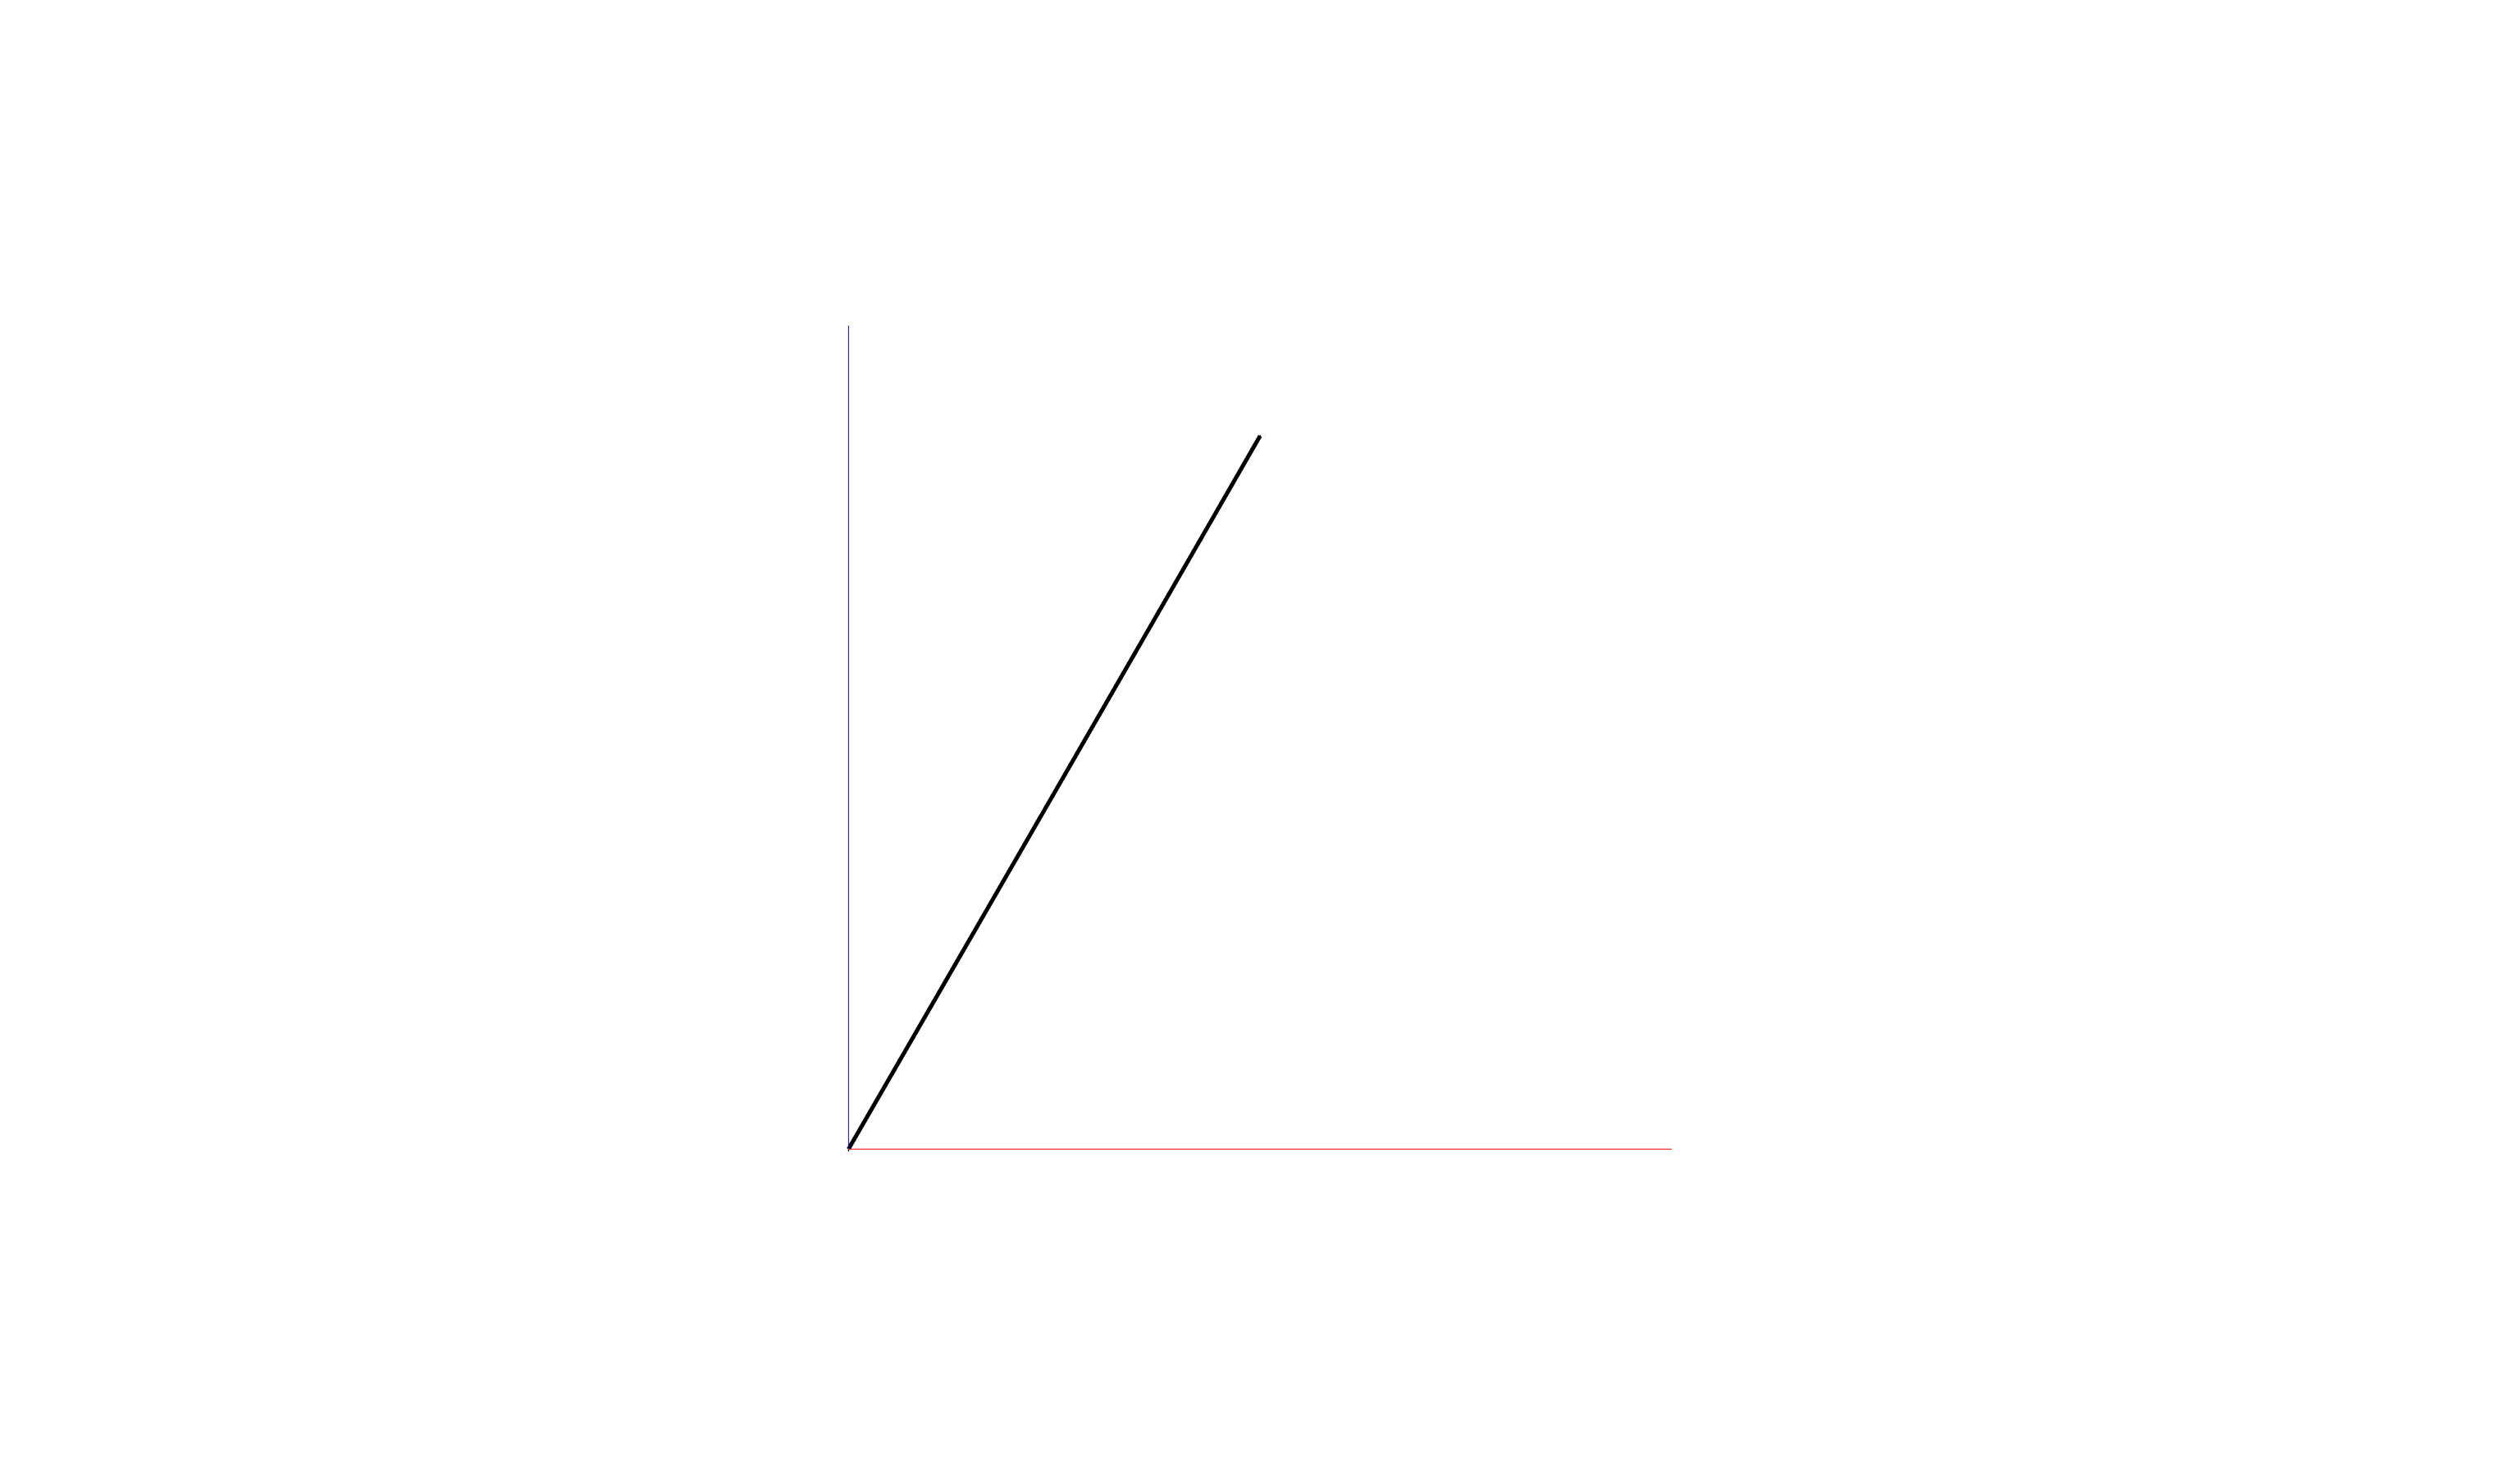

In [118]:
s = Scene()

EA = 2.5e5
L = 10
mass = 0.2
pre_tension = 500

s.new_point(name='Left', position = (0,0,0))
s.new_point(name='Right',position=(L * np.cos(np.deg2rad(60)), 0 , L * np.sin(np.deg2rad(60))))
# code for cable
cab = s.new_cable(name='cable',
                  endA='Left',
                  endB='Right',
                  EA=EA,
                  mass=mass,
                  length = L
                  )
cab.set_length_for_tension(pre_tension) # neglecting mass

# equivalent discrete catenary
f1 = s.new_frame('f1', position = s['Left'].position)
f2 = s.new_frame('f2', position = s['Right'].position)

beam = s.new_beam('beam', f1, f2, EA = cab.EA, mass=cab.mass, n_segments=20, tension_only=True, L=cab.length)

s.solve_statics()
# Gui(s)

_add_weight_forces_as_forces(s, cab)

plotter = show(s, camera_pos=(4, -20, -11),
               projection='2d',
               lookat='y',
               force_do_normalize=False,
               force_scale=30.0,
               geometry_scale=0.01,
               painters='Construction',
               zoom_fit = True,
               )

In [119]:
report(s['cable'],'tension')
report(s['Right'],['fx','fz'])
report(s['f2'],('connection_force_x','connection_force_z'))
report(s['Left'],['fx','fz'])
report(s['f1'],('connection_force_x','connection_force_z'))

Property,Value,Unit,Remarks,Explained
tension,501.010,kN,,Tension in the cable


Property,Value,Unit,Remarks,Explained
fx,-250.018,kN,parent axis,x component of applied force
fz,-434.023,kN,parent axis,z component of applied force


Property,Value,Unit,Remarks,Explained
connection_force_x,-250.020,kN,Parent axis,The x-component of the connection-force vector
connection_force_z,-434.026,kN,Parent axis,The z-component of the connection-force vector


Property,Value,Unit,Remarks,Explained
fx,250.018,kN,parent axis,x component of applied force
fz,432.065,kN,parent axis,z component of applied force


Property,Value,Unit,Remarks,Explained
connection_force_x,250.019,kN,Parent axis,The x-component of the connection-force vector
connection_force_z,432.068,kN,Parent axis,The z-component of the connection-force vector


This check for a typical lifting situation shows that the accuracy is more than sufficient for rigging calculations.